# Linear Regression

In [11]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline

In [35]:
n_samples = 10000
n_features = 1
bias = np.random.rand()*10
noise_std = np.random.rand()*100

X, y, beta_true = make_regression(n_samples=n_samples, 
                                  n_features=n_features, 
                                  bias=bias, 
                                  noise=noise_std, 
                                  coef=True)
beta_true = np.append(bias, beta_true).reshape((-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

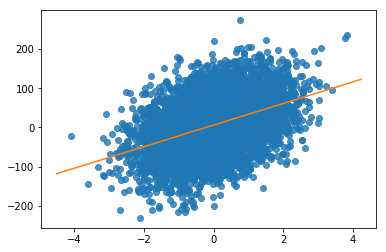

In [36]:
ax = sns.regplot(X_train, y_train, fit_reg=False)
xmin, xmax = ax.get_xlim()
xs = np.append(np.ones((100, 1)), np.linspace(xmin, xmax, 100)[:, np.newaxis], axis=1)
ys_true = xs.dot(beta_true)
plt.plot(xs[:, 1], ys_true)

## Frequentist Linear Regression

The frequentist, or classical, approach to multiple linear regression assumes a model of the form

$$\begin{eqnarray}
f \left( \mathbf{X} \right) = \beta_0 + \sum_{j=1}^p \mathbf{X}_j \beta_j + \epsilon = \beta^T \mathbf{X} + \epsilon
\end{eqnarray}\qquad \epsilon \sim \mathcal{N}(0,\sigma^2)$$

The most popular method to do this is via ordinary least squares (OLS). If we define the residual sum of squares (RSS), which is the sum of the squared differences between the outputs and the linear regression estimates:

$$
\begin{eqnarray}
\text{RSS}(\beta) &=& \sum_{i=1}^{N} (y_i - f(x_i))^2 \\
                  &=& \sum_{i=1}^{N} (y_i - \beta^T x_i)^2
\end{eqnarray}
$$

Then the goal of OLS is to minimise the RSS, via adjustment of the $\beta$ coefficients. Although we won't derive it here the Maximum Likelihood Estimate of $\beta$, which minimises the RSS, is given by

$$
\begin{eqnarray}
\hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
\end{eqnarray}
$$

In [37]:
X_train = np.append(np.ones((X_train.shape[0], 1)), X_train, axis=1)
X_test = np.append(np.ones((X_test.shape[0], 1)), X_test, axis=1)

In [38]:
beta_estimates = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [39]:
y_pred = X_test.dot(beta_estimates)

In [40]:
mean_squared_error(y_pred=y_pred, y_true=y_test)

3651.4550971268181

## Bayesian linear regression

Let's assume the model to be in the usual form:

$$\begin{eqnarray}
f \left( \mathbf{X} \right) = \beta_0 + \sum_{j=1}^p \mathbf{X}_j \beta_j + \epsilon = \beta^T \mathbf{X} + \epsilon
\end{eqnarray}\qquad \epsilon \sim \mathcal{N}(0,\sigma^2)$$

Therefore, since the data vector $\mathbf{X}$ is usually considered not stochastic, we can say that $p(\mathbf{y} \mid \mathbf{X}, \beta, \sigma^2) \sim \mathcal{N}(\mathbf{y} \mid \mathbf{X}\beta,\sigma^2)$. 

A *likelihood function* describes the plausibility of a model parameter value, given specific observed data. The likelihood of the parameters $\beta$ is therefore:

$$
\mathcal{L}(\beta \mid \mathbf{y}) = p(\mathbf{Y} \mid \mathbf{X}, \beta, \sigma^2) = \prod^N_n p(y_n \mid x_n, \beta, \sigma^2) = \prod^N_n \mathcal{N}(y_n \mid \beta x_n, \sigma^2)
$$

We will define a *conjugate prior* $p(\beta)$ such that when we multiply the likelihood by it, we will get a function of the same form. Notice that $\mathcal{L}(\beta \mid \mathbf{y})$ is an exponential of a quadratic function of $\beta$. The corresponding conjugate prior is therefore 

$$
   p(\beta) = \mathcal{N}(\beta \mid m_0, S_0)
$$

The posterior distribution is 
$$
    p(\beta \mid \mathbf{y}) = \mathcal{N}(\beta \mid m_N, S_N)\\
    m_N = S_N(S_0^{-1}m_0 + \beta\Phi \mathbf{y})\\
    S_N^{-1} = S_0^{-1} + \beta\Phi^T\Phi
$$
where $\Phi$ is called *design matrix* and corresponds to

$$
\vec{\Phi} \equiv   \begin{bmatrix}
    1       & \vec{x}_1\\
    1       & \vec{x}_2\\
    \vdots  & \vdots   \\
    1       & \vec{x}_N 
\end{bmatrix} = \left[ \mathbf{1} \mid \mathbf{X} \right]
$$

In [9]:
alpha = 0.2
precision = 1/(noise_std**2)
m0 = np.array([0, 0]).reshape((-1, 1))
S0 = (1/alpha) * np.identity(X_train.shape[1])

In [10]:
SN = np.linalg.inv(np.linalg.inv(S0) + precision*X_train.T.dot(X_train))
mN = SN.dot(np.linalg.inv(S0).dot(m0) + precision*X_train.T.dot(y_train))

In [15]:
posterior = multivariate_normal(mean=mN.flatten(), cov=SN)

In [107]:
d_max_idx = np.unravel_index(np.argmax(d), d.shape)

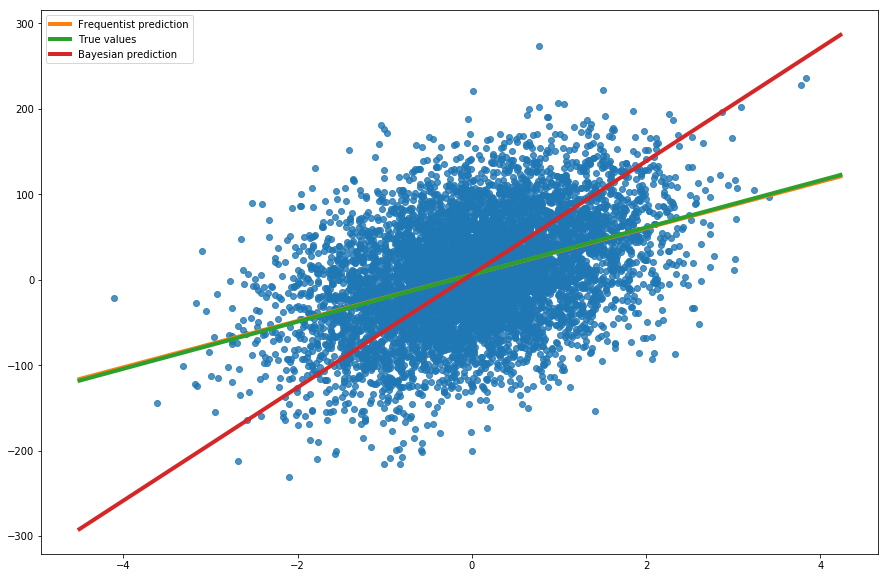

In [123]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(X_train[:, 1], y_train, fit_reg=False)
xmin, xmax = ax.get_xlim()
xs = np.append(np.ones((100, 1)), np.linspace(xmin, xmax, 100)[:, np.newaxis], axis=1)
ys_pred_lin = xs.dot(beta_estimates)
plt.plot(xs[:, 1], ys_pred_lin, linewidth=4, label = "Frequentist prediction")
ys_true = xs.dot(beta_true)
plt.plot(xs[:, 1], ys_true, linewidth=4, label = "True values")
ys_pred_bay = xs.dot(mN)
plt.plot(xs[:, 1], ys_pred_bay, linewidth=4, label = "Bayesian prediction")
plt.legend()